In [79]:
# import pyodide_js
# await pyodide_js.loadPackage('matplotlib')
# await pyodide_js.loadPackage('scikit-learn')
# await pyodide_js.loadPackage('xgboost')

In [80]:
import pandas as pd

from electric_cars.view import plot_column
from electric_cars.utils import load_data, preview_table, describe_column, fit_predicting_model, make_prediction, stack_tables, join_tables, apply_calculation_to_row, aggregate_sum

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Hypothèses

Here are some key assumptions that you may potentially need for the modeling:
- In France, about 20% of the electric vehicle charging needs are covered through home charging outlets.
- Vehicle traffic in France is heavily dependent on the time of day. It can be considered that it is doubled during the following time slots: 6:30-9:30, 12:00-14:00, 16:30-19:30.
- There is no competition between the various players on the selling price of electricity.
- The average speed for a home - work journey is 45 km/h (about 28 mph).
- The choice of charging stations in an area does not depend on the characteristics of the available stations.
- A French person uses their car on average 4 times a week.

# Available functions

Here is the list of functions made available to you:
- `load_data()`: loads the data from the csv files
- `preview_table(table)`: prints the first 5 rows of the table
- `describe_column(table, column_name)`: prints the description of the column
- `plot_column(table, column_name, zone_name)`: plots column_name for zone_name
- `fit_predicting_model(table, features, target, per_zone, model_type)`: fits a model on the table and returns it. The available model_types are "linear_regression", "decision_tree", "xgboost". per_zone = True will fit one independent model per zone while per_zone = False will fit the same model on all zones.
- `make_prediction(table, features, target, per_zone, model)`: makes a prediction on the table using the model. per_zone = True if you fitted independent models per zone, else False.
- `stack_tables(table_1, table_2, stack_type)`: stacks table_1 and table_2 either vertically or horizontally. Stack_type can be "vertical" or "horizontal".
- `join_tables(table_1, table_2, join_key, join_type)`: joins table_1 and table_2 on the join_key. Join_type can be "left", "right", "outer" or "inner".
- `apply_calculation_to_row(table, new_column_name, function, columns)`: applies the function to the columns and creates a new column named new_column_name
- `aggregate_sum(table, column_name, new_column_name)`: aggregates the column_name by summing it and creates a new column named new_column_name

# 0. Loading data

In [81]:
table_1, table_2, table_3, table_4, table_5 = load_data()

# I. Data exploration

In [82]:
preview_table(table_1)

,Date,Zone Name,Rainy Day,Population,Median Salary (EUR),Shops per 1k hab,Hospitals per 1M hab,Childcare per 100 children under 3 y.o.,Public_Transport_Quality,Infrastructure_Quality,Traffic,weekend
0,2012-01-01,Zone A,0,37489.3834,2028.4367,46.9499,45.8929,15.8448,0.0630,0.1187,18693.0,1
1,2012-01-02,Zone A,1,37489.4073,2028.4421,46.9491,45.8939,15.8445,0.0630,0.1187,18337.0,0
2,2012-01-03,Zone A,1,37489.4312,2028.4474,46.9483,45.8948,15.8442,0.0630,0.1187,18337.0,0
3,2012-01-04,Zone A,1,37489.4551,2028.4528,46.9475,45.8958,15.8439,0.0630,0.1187,18337.0,0
4,2012-01-05,Zone A,0,37489.4790,2028.4581,46.9468,45.8967,15.8436,0.0631,0.1188,17803.0,0
5,2012-01-06,Zone A,0,37489.5029,2028.4635,46.9460,45.8977,15.8433,0.0631,0.1188,17803.0,0
6,2012-01-07,Zone A,0,37489.5268,2028.4688,46.9452,45.8987,15.8430,0.0631,0.1188,18693.0,1
7,2012-01-08,Zone A,1,37489.5507,2028.4742,46.9445,45.8996,15.8427,0.0631,0.1188,19253.0,1
8,2012-01-09,Zone A,1,37489.5746,2028.4796,46.9437,45.9006,15.8424,0.0631,0.1188,18337.0,0
9,2012-01-10,Zone A,1,37489.5985,2028.4849,46.9429,45.9015,15.8420,0.0631,0.1188,18337.0,0


In [83]:
describe_column(table_1, 'Zone Name')

count      12054
unique         3
top       Zone A
freq        4018
Name: Zone Name, dtype: object

####################
Zone A    4018
Zone B    4018
Zone C    4018
Name: Zone Name, dtype: int64


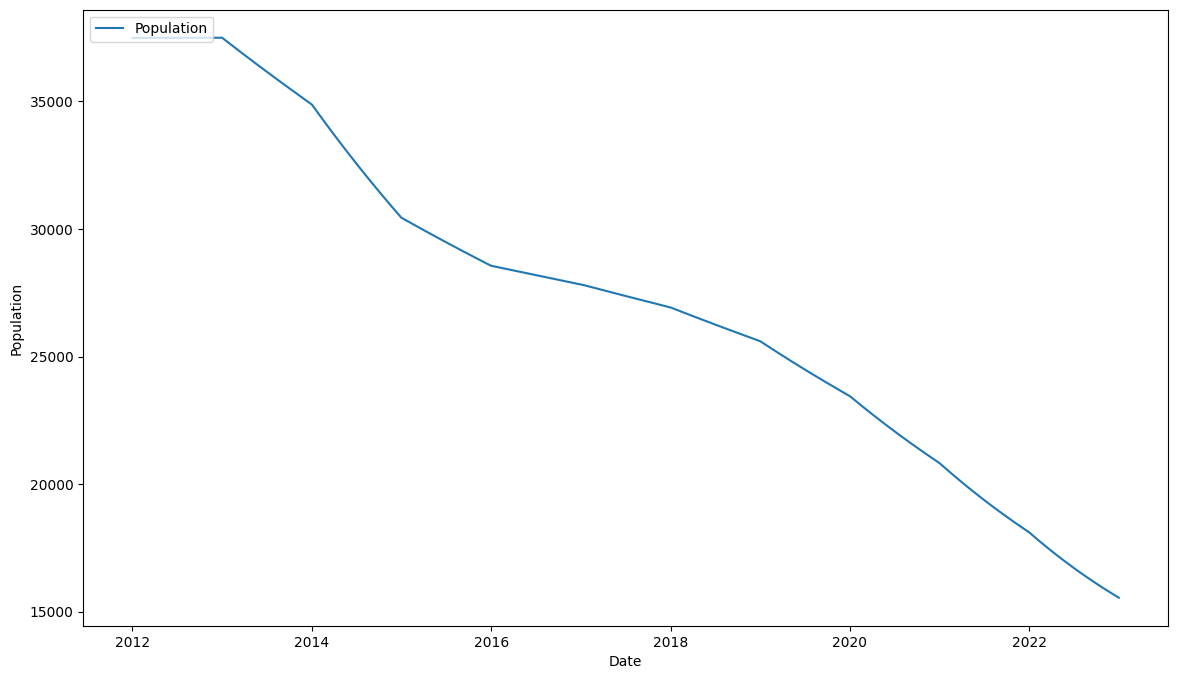

In [84]:
plot_column(table_1, 'Population', 'Zone A')

# II. Predicting sales

Linear Regression
Mean Absolute Error: 15.43
R^2 Score: 0.9993120040189651


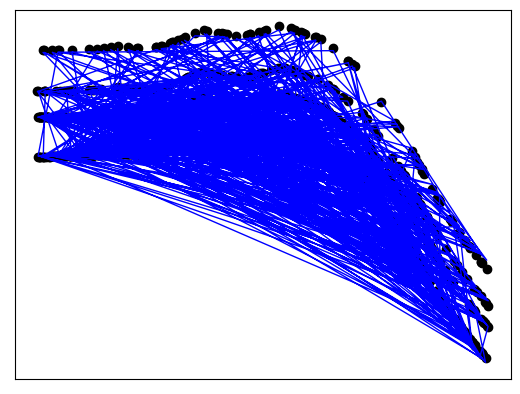

Linear Regression
Mean Absolute Error: 36.13
R^2 Score: 0.9993478901367848


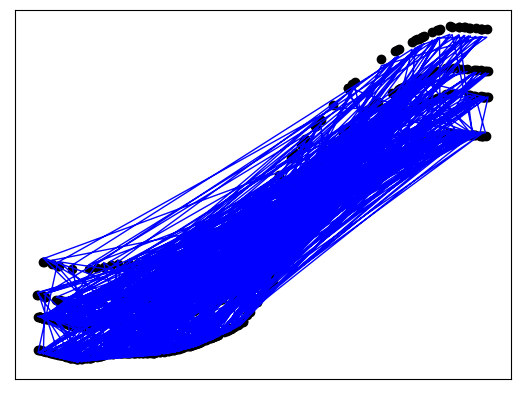

Linear Regression
Mean Absolute Error: 24.54
R^2 Score: 0.9993786084151084


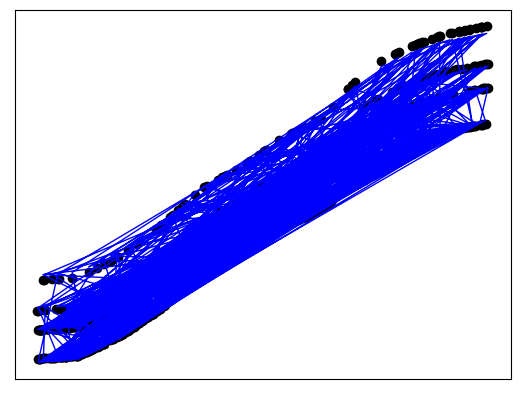

In [42]:
# Predict traffic

drivers = [
    'Population',
    'Median Salary (EUR)',
    'Shops per 1k hab',
    'Hospitals per 1M hab',
    'Childcare per 100 children under 3 y.o.',
    'Public_Transport_Quality',
    'Infrastructure_Quality',
    'weekend',
    'Rainy Day'
]


model = fit_predicting_model(table_1, drivers, 'Traffic', True, 'linear_regression')

table_2 = make_prediction(table_2, drivers, 'Traffic', True, model)

table_12 = stack_tables(table_1, table_2, "vertical")

In [85]:
# Determing daily demand

table_123 = join_tables(table_12, table_3, join_key=['Date', 'Zone Name'], join_type='left')

def mult(x, y, z, t):
    return x * y * z * t

table_123 = apply_calculation_to_row(table_123, 'External Charging Need (kWh/day)', mult, ['Traffic', '% Electric Cars', 'Average Consumption (kWh/km)', 'Average Daily Distance (km/day)'])

def eighty_percent(x):
    return x * (1 - 0.2)

table_123 = apply_calculation_to_row(table_123, 'External Charging Need (kWh/day)', eighty_percent, ['External Charging Need (kWh/day)'])

In [86]:
# Determining daily offer 

table_45 = stack_tables(table_4, table_5, "vertical")
table_45 = aggregate_sum(table_45, "Zone Name", "Station Size (kW)")

def to_day(x):
    return x * 24

table_45 = apply_calculation_to_row(table_45, 'Daily capacity (kWh/day)', to_day, ['Station Size (kW)'])

In [88]:
# Determining daily sales
def f(x, y):
    return min(x / 2, y / 3) + min(x / 2, y * 2 / 3)

table_all = join_tables(table_123, table_45, join_key=['Zone Name'], join_type='left')

table_all = apply_calculation_to_row(table_all, 'Daily sales (kWh/day)', f, ['External Charging Need (kWh/day)', 'Daily capacity (kWh/day)'])

In [89]:
# Determining market share
table_4_bis = aggregate_sum(table_4, "Zone Name", "Station Size (kW)")
table_5_bis = aggregate_sum(table_5, "Zone Name", "Station Size (kW)")
table_market_share = join_tables(table_4_bis, table_5_bis, join_key=['Zone Name'], join_type='outer')

def divide(x, y):
    return x / y

table_market_share = apply_calculation_to_row(table_market_share, 'Market_share', divide, ['Station Size (kW)_x', 'Station Size (kW)_y'])


In [90]:
# Determining client sales
table_all_bis = join_tables(table_all, table_market_share, join_key=['Zone Name'], join_type='left')

def multiply(x, y):
    return x * y

table_all_bis = apply_calculation_to_row(table_all_bis, 'Client Daily sales (kWh/day)', multiply, ['Daily sales (kWh/day)', 'Market_share'])

In [91]:
table_all_bis.head()

,Date,Zone Name,Rainy Day,Population,Median Salary (EUR),Shops per 1k hab,Hospitals per 1M hab,Childcare per 100 children under 3 y.o.,Public_Transport_Quality,Infrastructure_Quality,Traffic,weekend,% Electric Cars,Average Consumption (kWh/km),Average Daily Distance (km/day),External Charging Need (kWh/day),Station Size (kW),Daily capacity (kWh/day),Daily sales (kWh/day),Station Size (kW)_x,Station Size (kW)_y,Market_share,Client Daily sales (kWh/day)
0,2012-01-01,Zone A,0,37489.3834,2028.4367,46.9499,45.8929,15.8448,0.0630,0.1187,18693.0,1,0.35,0.052425,35.93,9858.903925,351.4,8433.6,7740.651962,24.0,327.4,0.073305,567.427144
1,2012-01-02,Zone A,1,37489.4073,2028.4421,46.9491,45.8939,15.8445,0.0630,0.1187,18337.0,0,0.35,0.052420,35.93,9670.355852,351.4,8433.6,7646.377926,24.0,327.4,0.073305,560.516403
2,2012-01-03,Zone A,1,37489.4312,2028.4474,46.9483,45.8948,15.8442,0.0630,0.1187,18337.0,0,0.35,0.052416,35.93,9669.566289,351.4,8433.6,7645.983144,24.0,327.4,0.073305,560.487463
3,2012-01-04,Zone A,1,37489.4551,2028.4528,46.9475,45.8958,15.8439,0.0630,0.1187,18337.0,0,0.35,0.052412,35.93,9668.776725,351.4,8433.6,7645.588362,24.0,327.4,0.073305,560.458524
4,2012-01-05,Zone A,0,37489.4790,2028.4581,46.9468,45.8967,15.8436,0.0631,0.1188,17803.0,0,0.35,0.052407,35.93,9386.441371,351.4,8433.6,7504.420686,24.0,327.4,0.073305,550.110252


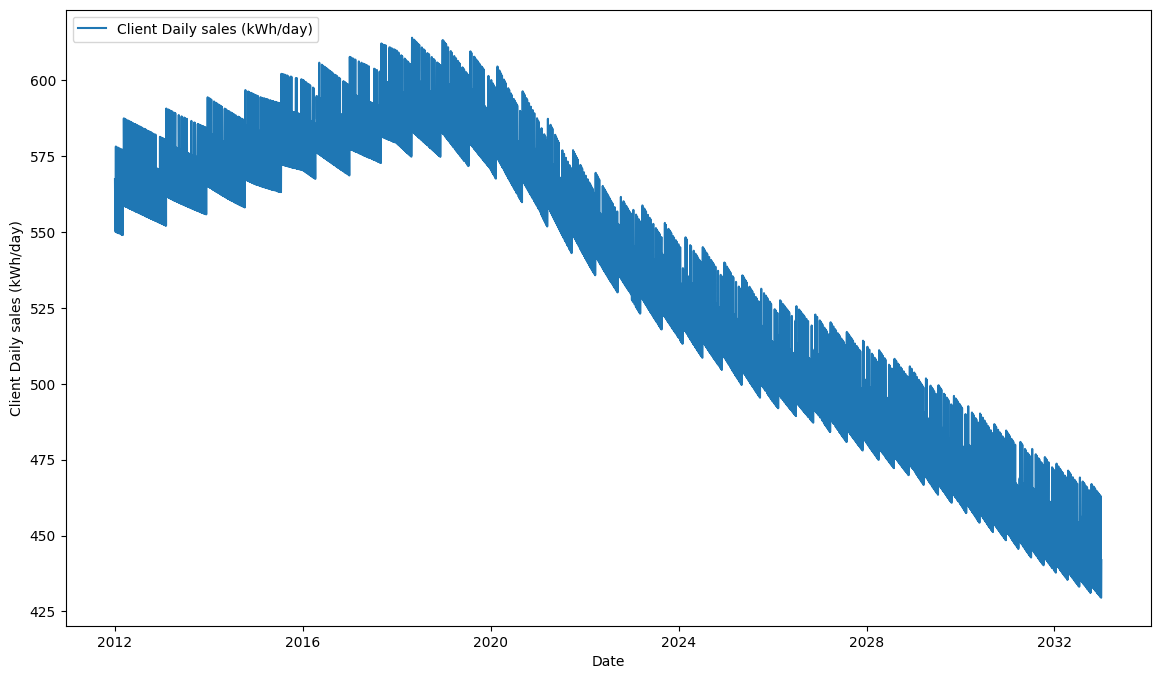

In [92]:
plot_column(table_all_bis, 'Client Daily sales (kWh/day)', 'Zone A')

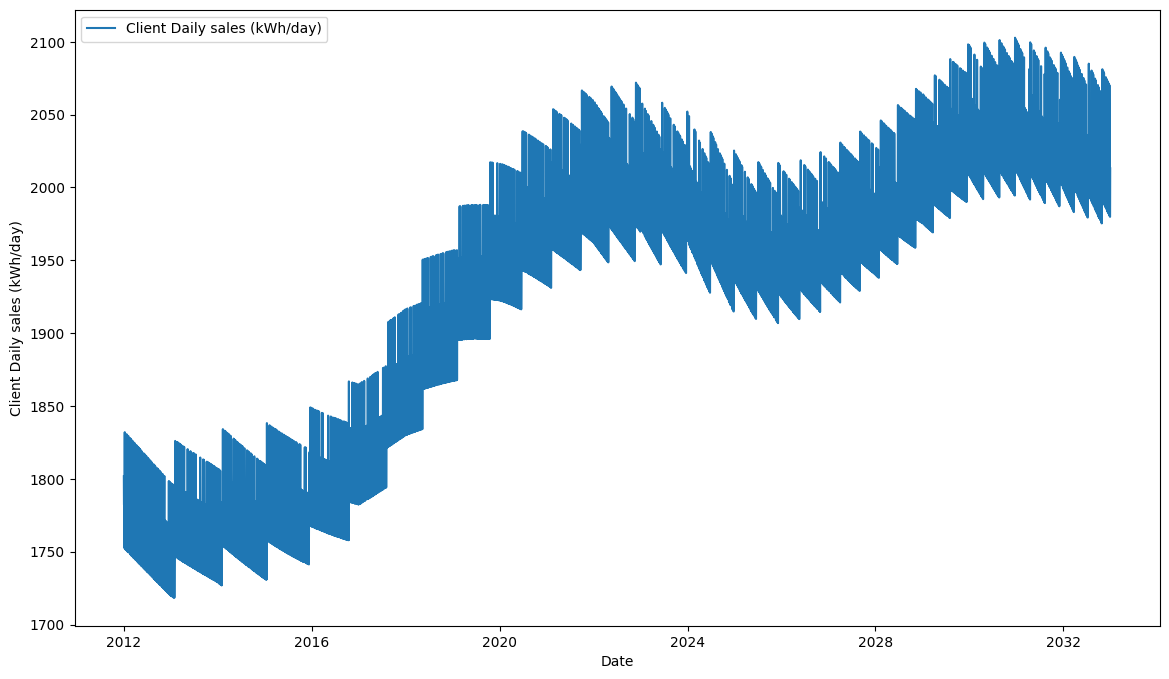

In [93]:
plot_column(table_all_bis, 'Client Daily sales (kWh/day)', 'Zone B')

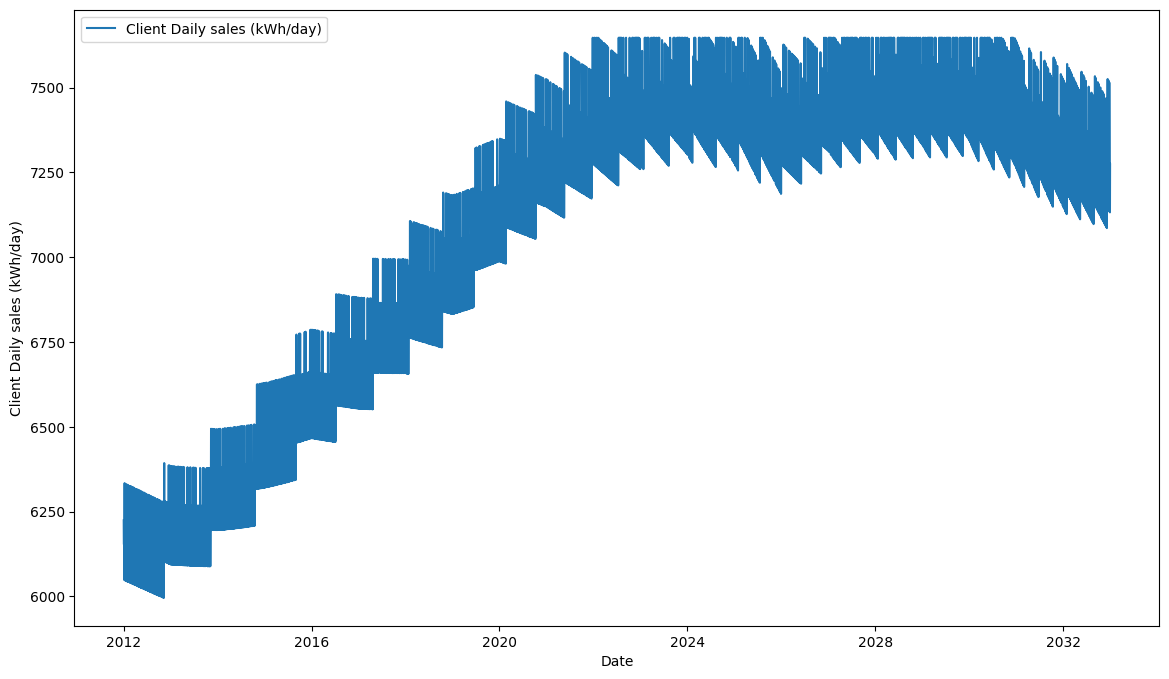

In [94]:
plot_column(table_all_bis, 'Client Daily sales (kWh/day)', 'Zone C')